# End to end 2D CNN for GTzan music classification


WINDOWED Version

Adapted by AL Koerich

- Modified by KM Koerich

To GTzan 3-fold

11 December 2018

- Last Update: 08 August 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os, sys
import soundfile as sf
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from keras import regularizers

import os, sys
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten
from keras.callbacks import TensorBoard
from keras.utils import np_utils, to_categorical
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
import keras.initializers as init
from keras.utils.training_utils import multi_gpu_model

os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
config = tf.ConfigProto( )
config.gpu_options.allow_growth = True
sess   = tf.Session(config=config)
import keras.backend.tensorflow_backend as tf_bkend
tf_bkend.set_session(sess)

Using TensorFlow backend.


In [2]:
#controling_Hyper parameters

nb_classes = 10
nb_epoch   = 150
frame_size = 110250

In [3]:
#Indicate folds
train_fold = [1, 2]
test_fold = 3

str_train_fold = "fold"+str(train_fold[0])+"-"+str(train_fold[1])
print(str_train_fold)

fold1-2


In [4]:
X_train = np.load( "folds_stft/2_GTzan_Xs_train_"+str_train_fold+"_110250_75_frozen_stft.npy")

In [5]:
Y_train = np.load( "folds_stft/2_GTzan_Ys_train_"+str_train_fold+"_110250_75_frozen_stft.npy" )

In [6]:
Y_train.min(), Y_train.max(), Y_train.shape

(0.0, 1.0, (14051, 10))

In [7]:
# Adapt 1D data to 2D CNN
X_train = np.squeeze(X_train)
X_train = np.expand_dims(X_train, axis = 3)

In [8]:
X_train.shape

(14051, 257, 431, 1)

In [9]:
gc.collect()

13

In [10]:
f = X_train.shape[1]
g = X_train.shape[2]

In [11]:
def model_generator_GTzannet2D_1a():
    
    from keras.layers      import Input, Dense, Conv2D, AveragePooling1D, LeakyReLU, MaxPool2D, Flatten
    from keras.layers.core import Dropout
    from keras.models      import Model
    from keras             import initializers, optimizers, regularizers
    from keras.callbacks   import ModelCheckpoint
    from keras.utils       import multi_gpu_model
    
    from keras.layers.normalization import BatchNormalization
        
    import keras.initializers as init

    from kapre.utils          import Normalization2D
    from kapre.augmentation   import AdditiveNoise    
    
    sr = 22050
    
    inp   = Input(shape = (f, g, 1)) 
    #----------------------
    conv1  = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')(inp)
    norm1  = BatchNormalization()(conv1)
    #----------------------
    conv2  = Conv2D(filters = 32, kernel_size = (3, 3) )(norm1)
    act2   = LeakyReLU(alpha = 0.2)(conv2)
    pool2  = MaxPool2D(pool_size = 2, strides = 2)(act2)
    drop2  = Dropout(0.05)(pool2)
    #----------------------
    conv3  = Conv2D(filters = 64, kernel_size = (3, 3) )(drop2)
    act3   = LeakyReLU(alpha = 0.2)(conv3)
    #----------------------
    conv4  = Conv2D(filters = 64, kernel_size = (3, 3) )(act3)
    act4   = LeakyReLU(alpha = 0.2)(conv4)
    pool4  = MaxPool2D(pool_size = 4, strides = 2)(act4)
    #----------------------
    flat   = Flatten()(pool4)  
    #----------------------    
    dense3 = Dense(512, activation='relu', kernel_initializer = initializers.glorot_uniform(seed = 0))(flat)
    #dense3 = Dense(1024, activation='relu', kernel_initializer = initializers.glorot_uniform(seed = 0))(flat)
    drop3  = Dropout(0.80)(dense3)    
    #----------------------
    dense4 = Dense(nb_classes, activation='softmax')(drop3)
    #----------------------

    model  = Model(inp, dense4)

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizers.Adadelta(lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
                  metrics = ['accuracy'] )
    
    model.summary()
    
    return model

In [12]:

import time
from keras.callbacks import ModelCheckpoint
from livelossplot    import PlotLossesKeras
from keras           import optimizers
hist = []

#ale = model_generator_GTzannet2D_1a()
model = model_generator_GTzannet2D_1a()
#model = multi_gpu_model(ale, gpus=2)

#checkpoints
str0 = "weights/"
str1 = "weights_3_GTzan_3f_"+str_train_fold+"_20p_110250_75_frozen_stft" 
str2 = ".best.hdf5" 
filepath = str0+str1+str2
print(filepath)

checkpoint = ModelCheckpoint( filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max' ) 

callbacks_list = [checkpoint, PlotLossesKeras()]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 257, 431, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 255, 429, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 255, 429, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 253, 427, 32)      9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 253, 427, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 213, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 213, 32)      0         
__________

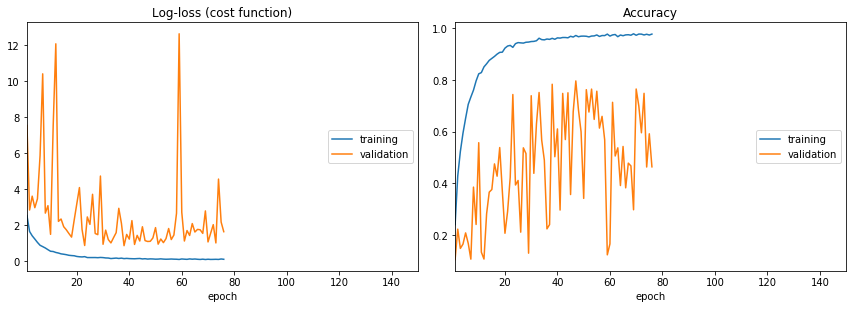

Log-loss (cost function):
training   (min:    0.080, max:    2.529, cur:    0.093)
validation (min:    0.850, max:   12.650, cur:    1.629)

Accuracy:
training   (min:    0.240, max:    0.979, cur:    0.978)
validation (min:    0.104, max:    0.797, cur:    0.464)
Epoch 77/150
 9030/11240 [=======================>......] - ETA: 19s - loss: 0.0644 - acc: 0.9796

KeyboardInterrupt: 

In [13]:
#fitting the model
gc.collect()
batch_size = 35
hist.append(model.fit(X_train, Y_train,
                      batch_size = batch_size, 
                      epochs     = nb_epoch,
                      verbose    = 1,
                      shuffle    = True,
                      callbacks  = callbacks_list,
                      validation_split = 0.2
                     ))

In [ ]:
filepath

https://www.music-ir.org/nema_out/mirex2017/results/act/latin_report/accperfold.html

MIREX 2017:



Summary Results    [top]
Algorithm
Classification Accuracy
Normalised Classification Accuracy
LPNKK1
0.7586
0.7571
PLNPH1
0.6619
0.6573
XLJ1
0.6148
0.6079
LPNKK3
0.7347
0.7324
LPNKK2
0.6511
0.6458





Fold
LPNKK1
LPNKK2
LPNKK3
PLNPH1
XLJ1
1
0.7186
0.6041
0.6860
0.5795
0.5453
0
0.7627
0.6426
0.7444
0.6772
0.5998
2
0.8055
0.7194
0.7872
0.7518
0.7183


/Users/akoerich/Dropbox/Mendeley/pdf/Aytar, Vondrick, Torralba - 2016.pdf

/Users/akoerich/HOME/ETS/Etudiants/Sajjad Abdoli/DGA1032/DGA1032-Dissertation_abdoli.pdf